In [27]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [28]:
import tensorflow as tf

In [29]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [30]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [31]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [32]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5

In [33]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28, 1)
(60000,)


In [34]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [35]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    # shape 7,7,256
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #shape 7,7,128
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #shape 14,14,128
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    #shape 28,28,1

    return model

In [37]:
generator=make_generator_model()

In [38]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise,training=False)

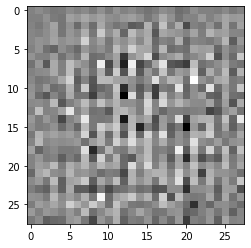

In [39]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [40]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [41]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00182607]], shape=(1, 1), dtype=float32)


In [42]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [43]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [44]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [45]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [46]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [47]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [48]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
#print(seed)

In [49]:
@tf.function
def train_steps(images):
    noise=tf.random.normal([BATCH_SIZE,noise_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as dis_tape:
        
        generated_images=generator(noise,training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss=generator_loss(fake_output)
        dis_loss=discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [50]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()
        
        for image_batch in dataset:
            train_steps(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)
        
        if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)
                
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

In [51]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

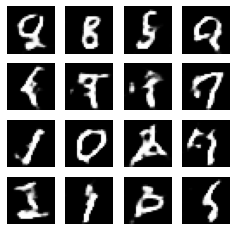

In [52]:
train(train_dataset, EPOCHS)

In [53]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


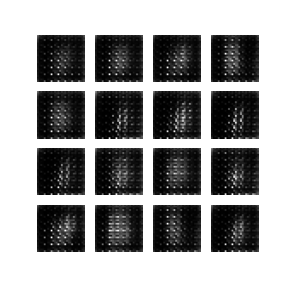

In [54]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)